# Quantum Nearest Centroid 

---

Qiskit implementation of quantum nearest centroid algorithm based on [this paper.](https://www.nature.com/articles/s41534-021-00456-5.pdf)
$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}|{#2}\right\rangle}
$$
The algorithm takes a parameter, $d$, that defines the input vector dimension. For example, an input data point $x$ has the following shape:

$$
x = (x_1, x_2, ..., x_d) \in \mathbb{R}^d
$$


For input vector in $\mathbb{R}^d$, the algorithm requires exactly $d$ qubits, $d-1$ parameterized two-qubit gates, and a circuit depth of $\log(d)$.

We start by producing two normalized random vectors in $\mathbb{R}^d$ from a uniform distribution $U(0,1)$.

In [1]:
import logging
import numpy as np

# Logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Algorithm parameters
# assuming d is a power of two for simplicity
DIMENSION: int = 8
total_shots: int = 4096
    
vector1: np.array = np.random.uniform(size=(DIMENSION,))
vector2: np.array = np.random.uniform(size=(DIMENSION,))

point1: np.array = vector1 / np.linalg.norm(vector1)
point2: np.array = vector2 / np.linalg.norm(vector2)
    
logging.info("Input vector 1: %s", point1)
logging.info("Input vector 2: %s", point2)

INFO:root:Input vector 1: [0.42473536 0.11454373 0.41186325 0.05886383 0.45531106 0.5393435
 0.0788628  0.35911614]
INFO:root:Input vector 2: [0.38731463 0.00170976 0.53282832 0.4217796  0.1066108  0.49917578
 0.35309318 0.05443607]


Ultimately, we want to compute the Euclidean distance between $x$ and $y$. That is, given two classical data points $x$ and $y$, compute $I_{xy} = ||x - y||$, given by:

$$I_{xy} = \sqrt{||x||^2 + ||y||^2 - 2||x||||y||c_{xy}}$$

where $c_{xy} = \braket{x}{y}$ is the inner product of the two normalized vectors. When asked to find the Euclidean distance, we can apply the quantum circuit to estimate the inner product.

In [2]:
# Classically compute the inner product
ip: float = np.inner(point1, point2)
    
# Classically compute euclidean distance
ed: float = np.linalg.norm(point1 - point2)
logging.info("Euclidean distance of x and y: %s", ed)

INFO:root:Euclidean distance of x and y: 0.6720935862850054


## Quantum Circuit

---

The quantum circuit consists of two parts, the parallel loader for the first data point, and the inverse parallel loader for the second data point. For $d=8$, an example circuit is shown below:


<img src="img/circuit_example.png" alt="Drawing" style="width: 500px;"/>

The data loader circuit, given access to a data point $x$, outputs a parameterized quantum circuit that prepares quantum states of the form:

$$
\frac{1}{||x||} \sum_{i=1}^d x_i \ket{i}
$$

The circuit makes use of a two-qubit parameterized gate $RBS(\theta)$ defined as:

$$
RBS(\theta) = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & \cos(\theta) & \sin(\theta) & 0 \\
0 & -\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

We can think of this gate as a simple rotation by an angle $\theta$ on the two-dimensional subspace spanned by the vectors $\{\ket{10}, \ket{01}\}$ and an identity in the other subspace spanned by $\{\ket{00}, \ket{11}\}$. The adjoint gate, $RBS^{\dagger}(\theta) = RBS(-\theta)$.

In [3]:
from qiskit.extensions import UnitaryGate

# Function that returns the RBS unitary matrix
def RBS_unitary(theta: float) -> np.matrix:
    return np.matrix([
        [1, 0, 0, 0],
        [0, np.cos(theta), np.sin(theta), 0],
        [0, -np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

# Function that returns an RBS gate
def RBS(theta: float) -> UnitaryGate:
    return UnitaryGate(RBS_unitary(theta), f"RBS({theta})")

# Function that returns the adjoint gate
def RBS_dagger(theta: float) -> UnitaryGate:
    return UnitaryGate(RBS_unitary(theta).H, f"RBS_dagger({theta})")


## Computing gate parameters

---

Classical preprocessing is required to obtain a set of parameters $\theta = (\theta_1, \theta_2,...,\theta_{d-1}) \in \mathbb{R}^{d-1}$. The algorithm described efficiently pre-processes the classical data in $O(d)$ time.

At a high level, we think of the coordinates $x_i$ as the leaves of a binary tree of depth $\log(d)$. The parameters $\theta$ correspond to the values of the internal tree nodes, starting from the root and going towards the leaves.

We first consider the parameter series $(r_1, r_2,...r_{d-1})$. For the last $d/2$ values $(r_{d/2},...,r_{d-1}$, we define and index $j$ that takes values in the interval $[1,d/2]$ and define the values as:

$$
r_{d/2 + j - 1} = \sqrt{x^2_{2j} + x^2_{2j - 1}}
$$

For the first $d/2 - 1$ values, namely the values of $(r_1, r_2, ..., r_{d/2 - 1})$, and for $j$ in $[1,d/2]$, we define:

$$
r_j = \sqrt{r^2_{2j + 1} + r^2_{2j}}
$$

We can now define the set of angles $\theta = (\theta_1, \theta_2,...,\theta_{d-1})$ in the following way. We start by defining the last $d/2$ values $(\theta_{d/2}, ..., \theta_{d-1})$. To do so, we define an index j that takes values in the interval $[1,d/2]$ and define the values as:

$$
\theta_{d/2 + j - 1} = \arccos\Big( \frac{x_{2j - 1}}{r_{d/2 + j - 1}} \Big), \; \text{if} \; x_{2j} \; \text{is positive}
$$

$$
\theta_{d/2 + j - 1} = 2\pi - \arccos\Big( \frac{x_{2j - 1}}{r_{d/2 + j - 1}} \Big), \; \text{if} \; x_{2j} \; \text{is negative}
$$

For the first $d/2 - 1$ values, namely the values for $j \in [1, d/2]$, we define:

$$
\theta_{j} = \arccos\Big(\frac{r_{2j}}{r_j}\Big)
$$

### Example Computation

In this example, DIMENSION = 8 => d/2 = 4, r = d - 1 = 7

r_values = (r_1,..., r_7) -> last d/2 values (r_4, r_5, r_6, r_7), first d/2 - 1 values (1, 2, 3)

Compute the last d/2 values (4, 5, 6, 7) where j = [1, d/2] = [1, 4] (inclusive)
* j = 1 (2j = 2): r_(4 + 1 - 1) = r_4 = sqrt(x_2^2 + x_1^2)
* j = 2 (2j = 4): r_(4 + 2 - 1) = r_5 = sqrt(x_4^2 + x_3^2)
* j = 3 (2j = 6): r_(4 + 3 - 1) = r_6 = sqrt(x_6^2 + x_5^2)
* j = 4 (2j = 8): r_(4 + 4 - 1) = r_7 = sqrt(x_8^2 + x_7^2)

Compute the first d/2 - 1 values (1, 2, 3) where j = [1, d/2] = [1, 4] (inclusive)
* j = 1 (2j = 2): r_1 = sqrt(r_3^2 + r_2^2)
* j = 2 (2j = 4): r_2 = sqrt(r_5^2 + r_4^2)
* j = 3 (2j = 6): r_3 = sqrt(r_7^2 + r_6^2)

Define a set of angles theta = (theta_1,...,theta_7)

Compute the last d/2 values -> (4, 5, 6, 7) where j = [1, d/2] = [1, 4]
* j = 1 (2j = 2): 
  * if x_2 positive: theta_(4 + 1 - 1) = theta_4 = arccos(x_1 / r_4) 
  * if x_2 negative: theta_(4 + 1 - 1) = theta_4 = 2pi - arccos(x_1 / r_4)
* j = 2 (2j = 4): 
  * if x_4 positive: theta_(4 + 2 - 1) = theta_5 = arccos(x_3 / r_5) 
  * if x_4 negative: theta_(4 + 2 - 1) = theta_5 = 2pi - arccos(x_3 / r_5)
* j = 3 (2j = 6):
  * if x_6 positive: theta_(4 + 3 - 1) = theta_6 = arccos(x_5 / r_6) 
  * if x_6 negative: theta_(4 + 3 - 1) = theta_6 = 2pi - arccos(x_5 / r_6)
* j = 4 (2j = 8):
  * if x_8 positive: theta_(4 + 4 - 1) = theta_7 = arccos(x_7 / r_7) 
  * if x_8 negative: theta_(4 + 4 - 1) = theta_7 = 2pi - arccos(x_7 / r_7)

Compute the first d/2 - 1 values -> (1, 2, 3) where j = [1, d/2] = [1, 4]
* j = 1 (2j = 2): theta_1 = arccos(r_2 / r_1)
* j = 2 (2j = 4): theta_2 = arccos(r_4 / r_2)
* j = 3 (2j = 6): theta_3 = arccos(r_6 / r_3)


In [4]:
# Function to compute angles given a normalized vector
def compute_angles(data: np.array) -> np.ndarray:
    """
    Compute the RBS gate parameters for a given input vector
    """
    
    # Array to hold r values
    r_values: np.ndarray = np.zeros(shape=(DIMENSION-1,))
    
    # Array to hold angles
    angles: np.ndarray = np.zeros(shape=(DIMENSION-1,))
        
    # Back index
    back_index_range = range(1, int(DIMENSION/2) + 1)
    front_index_range = range(1, int(DIMENSION/2))
    
    # Compute the last d/2 r values
    for j in back_index_range:
        two_j = 2*j
        r_index = int(DIMENSION/2) + j - 1
        first_x = two_j
        second_x = two_j - 1
        
        # Print indexes
        logging.info(f"j = {j} (2j = {two_j}): r_{r_index} = sqrt(x_{first_x}^2 + x_{second_x}^2)")
        
        # Pull indexes, accounting for zero vs. one-indexed array
        r_values[r_index - 1] = np.sqrt(data[first_x - 1]**2 + data[second_x - 1]**2)
        logging.info(f"________________r_{r_index} at index {r_index-1} = {r_values[r_index-1]}")
        
    # Compute the first d/2 - 1 r values
    for j in reversed(front_index_range):
        two_j = 2*j
        r_index = j
        first_r = two_j + 1
        second_r = two_j
        
        # Print indexes
        logging.info(f"j = {j} (2j = {two_j}): r_{r_index} = sqrt(r_{first_r}^2 + r_{second_r}^2)")
        
        # Pull indexes, accounting for zero vs. one-indexed array
        r_values[r_index - 1] = np.sqrt(r_values[first_r - 1]**2 + r_values[second_r - 1]**2)
        logging.info(f"________________r_{r_index} at index {r_index-1} = {r_values[r_index-1]}")
    
    # Compute the last d/2 theta values
    for j in back_index_range:
        two_j = 2*j
        theta_index = int(DIMENSION/2) + j - 1
        x_check_index = two_j
        x_index = two_j - 1
        r_index = theta_index
        
        logging.info(f"j = {j} (2j = {two_j}):")
        logging.info(f"____if x_{x_check_index} is positive, theta_{theta_index} = arccos(x_{x_index} / r_{r_index})")
        logging.info(f"____if x_{x_check_index} is negative, theta_{theta_index} = 2pi - arccos(x_{x_index} / r_{r_index})")
        
        # Run check
        if data[x_check_index - 1] >= 0:
            logging.info(f"________x_{x_check_index} ({data[x_check_index-1]}) is positive")
            angles[theta_index - 1] = np.arccos(data[x_index - 1] / r_values[r_index - 1])
            logging.info(f"________theta_{theta_index} at index {theta_index-1} = {angles[theta_index-1]}")
        else:
            logging.info(f"________x_{x_check_index} ({data[x_check_index-1]}) is negative")
            angles[theta_index - 1] = (2 * np.pi) - np.arccos(data[x_index - 1] / r_values[r_index - 1])
            logging.info(f"________theta_{theta_index} at index {theta_index-1} = {angles[theta_index-1]}")
    
    # Compute the first d/2 - 1 theta values
    for j in reversed(front_index_range):
        two_j = 2*j
        theta_index = j
        first_r = two_j
        second_r = j
        
        # Print values
        logging.info(f"j = {j} (2j = {two_j}): theta_{theta_index} = arccos(r_{first_r} / r_{second_r})")
        
        angles[theta_index - 1] = np.arccos(r_values[first_r - 1] / r_values[second_r - 1])
        logging.info(f"________theta_{theta_index} at index {theta_index-1} = {angles[theta_index-1]}")
    
    return angles

In [5]:
# Compute the angles for vector x
angles_x: np.array = compute_angles(point1)
angles_y: np.array = compute_angles(point2)

INFO:root:j = 1 (2j = 2): r_4 = sqrt(x_2^2 + x_1^2)
INFO:root:________________r_4 at index 3 = 0.43990952846105347
INFO:root:j = 2 (2j = 4): r_5 = sqrt(x_4^2 + x_3^2)
INFO:root:________________r_5 at index 4 = 0.41604842310110185
INFO:root:j = 3 (2j = 6): r_6 = sqrt(x_6^2 + x_5^2)
INFO:root:________________r_6 at index 5 = 0.7058325366517382
INFO:root:j = 4 (2j = 8): r_7 = sqrt(x_8^2 + x_7^2)
INFO:root:________________r_7 at index 6 = 0.3676734238533332
INFO:root:j = 3 (2j = 6): r_3 = sqrt(r_7^2 + r_6^2)
INFO:root:________________r_3 at index 2 = 0.7958538285415608
INFO:root:j = 2 (2j = 4): r_2 = sqrt(r_5^2 + r_4^2)
INFO:root:________________r_2 at index 1 = 0.6054887972504032
INFO:root:j = 1 (2j = 2): r_1 = sqrt(r_3^2 + r_2^2)
INFO:root:________________r_1 at index 0 = 1.0
INFO:root:j = 1 (2j = 2):
INFO:root:____if x_2 is positive, theta_4 = arccos(x_1 / r_4)
INFO:root:____if x_2 is negative, theta_4 = 2pi - arccos(x_1 / r_4)
INFO:root:________x_2 (0.11454373468071033) is positive
INF

## Put everything together

---

Now we can combine everything together to estimate the vector inner product of $x$ and $y$.

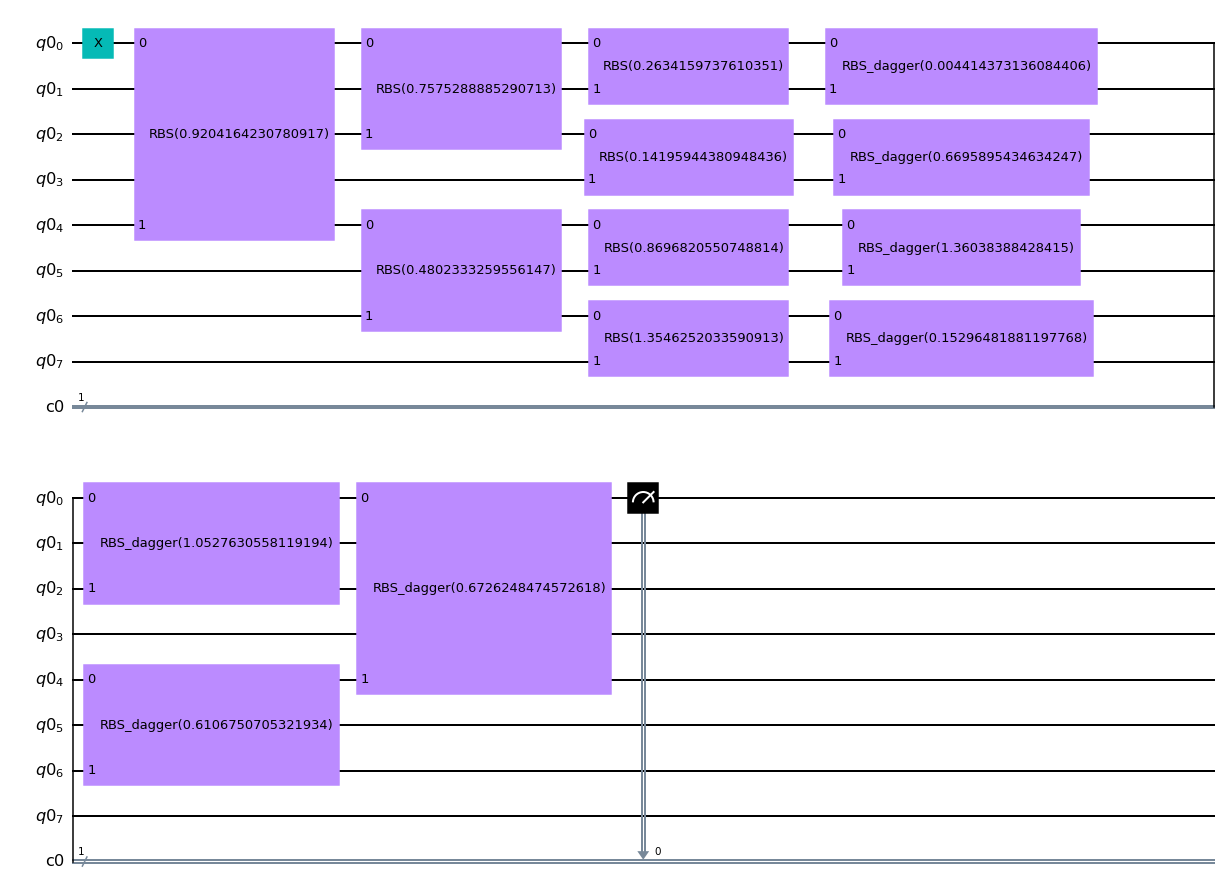

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

## Construct circuit with angles
qr = QuantumRegister(DIMENSION)
cr = ClassicalRegister(1)
circ = QuantumCircuit(qr, cr)

# For now, construct the circuit assuming d = 8
# eventually, we can write some general algorithm to
# construct a circuit for arbitrary d

# Parallel loader
circ.x(0)
circ.append(RBS(angles_x[0]), [0, 4])
circ.append(RBS(angles_x[1]), [0, 2])
circ.append(RBS(angles_x[2]), [4, 6])
circ.append(RBS(angles_x[3]), [0, 1])
circ.append(RBS(angles_x[4]), [2, 3])
circ.append(RBS(angles_x[5]), [4, 5])
circ.append(RBS(angles_x[6]), [6, 7])

# Inverse parallel loader
circ.append(RBS_dagger(angles_y[3]), [0, 1])
circ.append(RBS_dagger(angles_y[4]), [2, 3])
circ.append(RBS_dagger(angles_y[5]), [4, 5])
circ.append(RBS_dagger(angles_y[6]), [6, 7])
circ.append(RBS_dagger(angles_y[1]), [0, 2])
circ.append(RBS_dagger(angles_y[2]), [4, 6])
circ.append(RBS_dagger(angles_y[0]), [0, 4])

# Measure the zero-th qubit
circ.measure(qr[0], 0)

circ.draw('mpl')

#Note: Sometimes get that "Input matrix is not unitary"

In [8]:
# Simulate the quantum circuit
from qiskit import Aer, transpile

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(circ, backend_sim), shots=total_shots)

# Grab the results from the job.
result_sim = job_sim.result()

# Get counts
counts = result_sim.get_counts(circ)
logging.info(counts)

INFO:qiskit.compiler.assembler:Total Assembly Time - 0.11420 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.12088 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.09489 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.06175 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.06890 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.06390 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.06604 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.06223 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.08869 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.07224 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.11206 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.06723 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.13709 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.08965 (ms)
INFO:qiskit.compiler.assembler:Total Assembly Time - 0.07796 (ms)
INFO:qiski

### Estimate Inner Product

---

The quantum circuit we constructed produces a qubit whose probability of giving the outcome $\ket{1}$ is exactly the square of the inner product between the two normalized data points.

In [9]:
# Compute probability of 1
one_prob: float = float(counts['1'] / total_shots)

inner_product_estimate = np.sqrt(one_prob)

print("Estimated Inner Product:", inner_product_estimate)
print("True Inner Product:", ip)

Estimated Inner Product: 0.7726084571922572
True Inner Product: 0.7741451056372801
